In [ ]:
import os
import gzip
import pickle
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from utilsData import load_data_from_patients_folder, add_mean_SUV_index

In [ ]:
patients_data = load_data_from_patients_folder("../Data/PATIENTS")
patients_data = add_mean_SUV_index(patients_data)

controls_data = load_data_from_patients_folder("../Data/PATIENTS")
controls_data = add_mean_SUV_index(patients_data)

patients = patients_data.keys()
controls = controls_data.keys()

names = patients_data[patients[0]].loc["name"]
names = names.to_numpy()

# Verify the contents
print(f"Loaded data for {len(patients_data)}-{len(controls_data)} patients.")


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_37758/2476180969.py:23: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)
/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_37758/2476180969.py:23: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage 

Loaded data for 27 patients.


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_37758/2476180969.py:23: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [27]:
mean_SUV_by_names = {name: [patients_data[patient].loc[:, patients_data[patient].iloc[0] == name].loc["mean_SUV"].to_numpy()[0] for patient in patients] for name in names}
mean_SUV_by_names

{'spleen': [1.449441974630701,
  1.5614377042820962,
  1.2720645320460169,
  1.2007405290879207,
  1.3120001070831437,
  1.5760196007169411,
  1.9602528633437921,
  1.5253448367764872,
  1.6484909183951106,
  1.4902949414196878,
  1.7533477145801262,
  1.2033338802169669,
  1.8495046228830483,
  1.1903129375818335,
  1.4500800789338686,
  1.6804156691020635,
  1.707751846650515,
  1.1880842165464673,
  1.3231907615023846,
  1.9530625985954981,
  2.09417849508163,
  1.7232037413312742,
  1.7171446929402587,
  1.7447506865641673,
  2.109184991924757,
  1.7001604361267055,
  1.440376146477514],
 'kidney_right': [2.0264685494794032,
  1.689046068469159,
  1.236498126809475,
  2.0125250040916014,
  2.3594994303799908,
  2.401104554809795,
  1.8354176481510154,
  2.0995742021888564,
  2.434157590800791,
  2.8936598571038434,
  1.8958683488522807,
  1.6779055585708205,
  2.5091245030314897,
  1.5700503590200754,
  2.139659303330971,
  1.9133143286549876,
  2.3173942668825513,
  1.265021771176

In [ ]:
# Convert the dictionary into a DataFrame
mean_SUV_by_names_df = pd.DataFrame(mean_SUV_by_names)

# Calculate the correlation matrix
correlation_matrix = mean_SUV_by_names_df.corr()
#print(correlation_matrix)

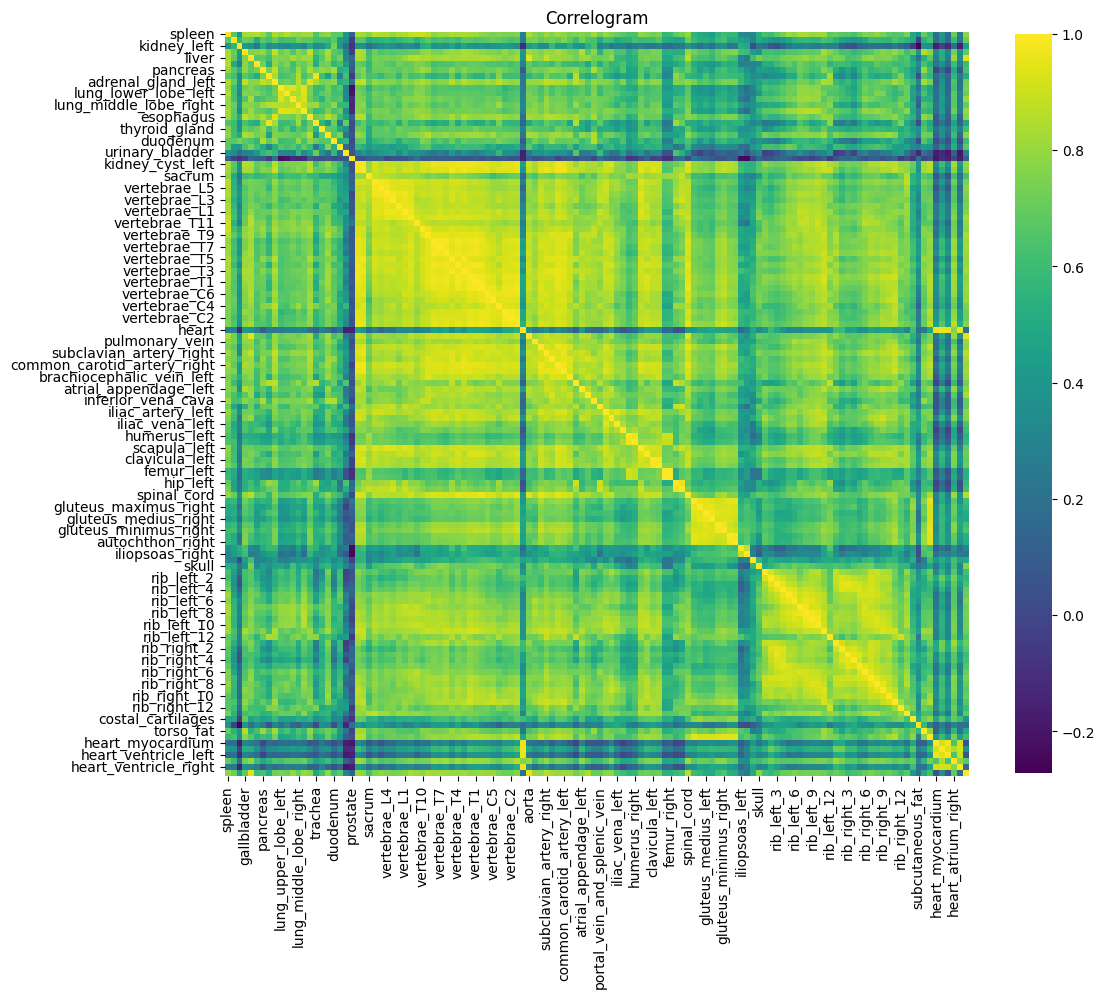

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='viridis',  # You can change this to another colormap like 'viridis' or 'RdBu_r'
    fmt='.2f',
    linewidths=0,  # Increase linewidth for better separation between cells
    cbar_kws={"shrink": 0.8},  # Shrink colorbar for better aesthetics
    annot_kws={"size": 12},  # Set font size of annotations
    square=True,  # Make the heatmap square-shaped
    linecolor='white'  # Add white lines between cells
)
plt.title('Correlogram')
plt.show()

In [35]:
correlation_matrix

,spleen,kidney_right,kidney_left,gallbladder,liver,stomach,pancreas,adrenal_gland_right,adrenal_gland_left,lung_upper_lobe_left,...,costal_cartilages,subcutaneous_fat,torso_fat,skeletal_muscle,heart_myocardium,heart_atrium_left,heart_ventricle_left,heart_atrium_right,heart_ventricle_right,pulmonary_artery
spleen,1.000000,0.662702,0.399816,0.825475,0.836127,0.849965,0.802205,0.673214,0.843235,0.792373,...,0.475201,0.374662,0.702812,0.581370,0.186522,0.401813,0.163537,0.705891,0.250532,0.781679
kidney_right,0.662702,1.000000,0.553040,0.703519,0.683158,0.507790,0.664655,0.622056,0.701681,0.609375,...,0.491363,-0.034453,0.541293,0.631592,0.185182,0.372406,0.192081,0.587209,0.244016,0.713016
kidney_left,0.399816,0.553040,1.000000,0.409863,0.379912,0.241217,0.535033,0.331167,0.387438,0.341496,...,-0.048897,-0.272057,0.388650,0.348159,-0.164711,-0.029964,-0.120875,0.181154,-0.159801,0.434670
gallbladder,0.825475,0.703519,0.409863,1.000000,0.753472,0.773759,0.791149,0.669868,0.883780,0.713491,...,0.688578,0.390457,0.857310,0.771603,0.316208,0.520328,0.309033,0.726080,0.361395,0.684430
liver,0.836127,0.683158,0.379912,0.753472,1.000000,0.662695,0.672874,0.607840,0.773785,0.759774,...,0.470361,0.208946,0.541831,0.671302,0.264051,0.512855,0.251472,0.801512,0.344965,0.937810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
heart_atrium_left,0.401813,0.372406,-0.029964,0.520328,0.512855,0.369950,0.190655,0.310857,0.358650,0.395282,...,0.663769,0.270157,0.372587,0.591036,0.907830,1.000000,0.931036,0.843058,0.918791,0.356987
heart_ventricle_left,0.163537,0.192081,-0.120875,0.309033,0.251472,0.174500,-0.019665,0.153063,0.136971,0.156841,...,0.515162,0.139223,0.168026,0.400144,0.974576,0.931036,1.000000,0.639318,0.896436,0.075176
heart_atrium_right,0.705891,0.587209,0.181154,0.726080,0.801512,0.599031,0.500743,0.559759,0.638854,0.616363,...,0.694026,0.311684,0.570662,0.736171,0.641829,0.843058,0.639318,1.000000,0.772179,0.682972
heart_ventricle_right,0.250532,0.244016,-0.159801,0.361395,0.344965,0.273605,0.083737,0.233583,0.193378,0.209995,...,0.597919,0.195620,0.227293,0.449850,0.907109,0.918791,0.896436,0.772179,1.000000,0.173026


The fully connected connectome

In [42]:
G = nx.Graph()
G.add_nodes_from(names)

for i in range(len(names)):
    for j in range(i + 1, len(names)):  # Only upper triangle (undirected graph)
        if correlation_matrix.loc[names[i], names[j]] != 0:  # Threshold to determine if an edge exists
            G.add_edge(names[i], names[j], weight=correlation_matrix.loc[names[i], names[j]])

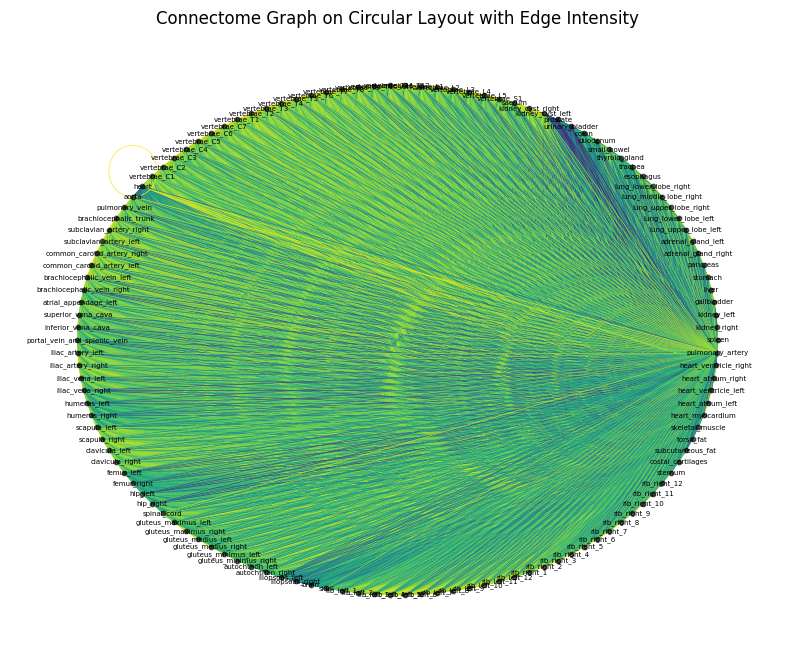

In [65]:
def plot_connectome(G):
    # Step 4: Visualization - Circular layout with colored edges
    plt.figure(figsize=(10, 8))

    # Get positions of nodes in a circular layout
    pos = nx.circular_layout(G)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='black', alpha=0.6)

    # Get edge weights for color mapping
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Normalize edge weights for color mapping
    norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))  # Normalize edge weights
    cmap = cm.viridis  # Use a colormap (can change to other colormaps like 'coolwarm')

    # Draw edges with colors based on weight
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color=edge_weights, edge_cmap=cmap, edge_vmin=min(edge_weights), edge_vmax=max(edge_weights))

    # Add node labels
    nx.draw_networkx_labels(G, pos, font_size=5, font_color='black')


    # Display the plot
    plt.title('Connectome Graph on Circular Layout with Edge Intensity')
    plt.axis('off')  # Hide axes for better aesthetics
    plt.show()
plot_connectome(G)

In [68]:
print(np.mean(correlation_matrix.to_numpy()))
print(np.max(correlation_matrix.to_numpy()))
print(np.min(correlation_matrix.to_numpy()))
print(np.mean(abs(correlation_matrix.to_numpy())))
print(np.median(abs(correlation_matrix.to_numpy())))
print(np.quantile(abs(correlation_matrix.to_numpy()), q=0.90))



0.6541608928022475
1.0
-0.2720565235762843
0.6554596917737132
0.6971165986996379
0.8816597824220844


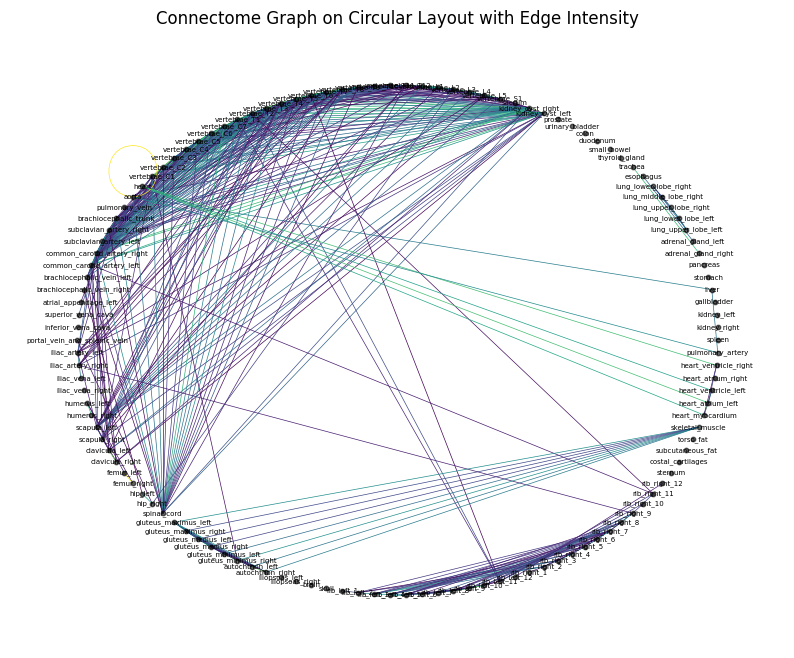

In [69]:
G_sparse = nx.Graph()
G_sparse.add_nodes_from(names)

for i in range(len(names)):
    for j in range(i + 1, len(names)):  # Only upper triangle (undirected graph)
        if abs(correlation_matrix.loc[names[i], names[j]]) > 0.9:  # Threshold to determine if an edge exists
            G_sparse.add_edge(names[i], names[j], weight=correlation_matrix.loc[names[i], names[j]])

plot_connectome(G_sparse)